In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
DATA_PATH = '../data/processed/final_integrated_dataset.csv'
OUTPUT_DIR = '../outputs/visualizations'
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
print('Rows:', len(df))
df.head()

Rows: 707348


,complaint_id,complaint_category,complaint_service,complaint_lat,complaint_lon,business_id,business_name,business_category,business_lat,business_lon,distance_m,similarity,score
0,17346520,ENVIRONMENTAL,GRAFFITI REMOVAL,39.963169,-75.166457,ZHYOgSeOUaJCy0PQ5tig-w,Community College of Philadelphia,shopping & stores & fashion,39.962937,-75.166508,26.21,0.0,0.5685
1,17346520,ENVIRONMENTAL,GRAFFITI REMOVAL,39.963169,-75.166457,DZaHxnUe4QZRqY16g_2-fw,Catalyst Cleanse,medical & health & life,39.963515,-75.166718,44.38,0.0,0.5467
2,17346520,ENVIRONMENTAL,GRAFFITI REMOVAL,39.963169,-75.166457,L04Lh8fHIrfD_hijTAP9qw,Julia Reynolds Masterman Laboratory and Demons...,shopping & stores & fashion,39.963209,-75.165808,55.54,0.0,0.5334
3,17346521,ENVIRONMENTAL,GRAFFITI REMOVAL,39.963625,-75.169500,y_j4V5xyL1tUfsnSIKNunQ,Hoorfar Dental Group- Philadelphia,medical & health & life,39.963682,-75.169199,26.45,0.0,0.5683
4,17346521,ENVIRONMENTAL,GRAFFITI REMOVAL,39.963625,-75.169500,ZbwNvz9TYU_ePG7ZmaAzMw,Sweetie's Pie Diner,restaurants & american & mexican,39.963266,-75.169224,46.39,0.0,0.5443


In [4]:
# Keep top match per complaint
top_idx = df.groupby('complaint_id')['score'].idxmax()
df_top = df.loc[top_idx].copy()
print('Top matches:', len(df_top))

Top matches: 242190


## 1) Complaint hotspots hexbin heatmap

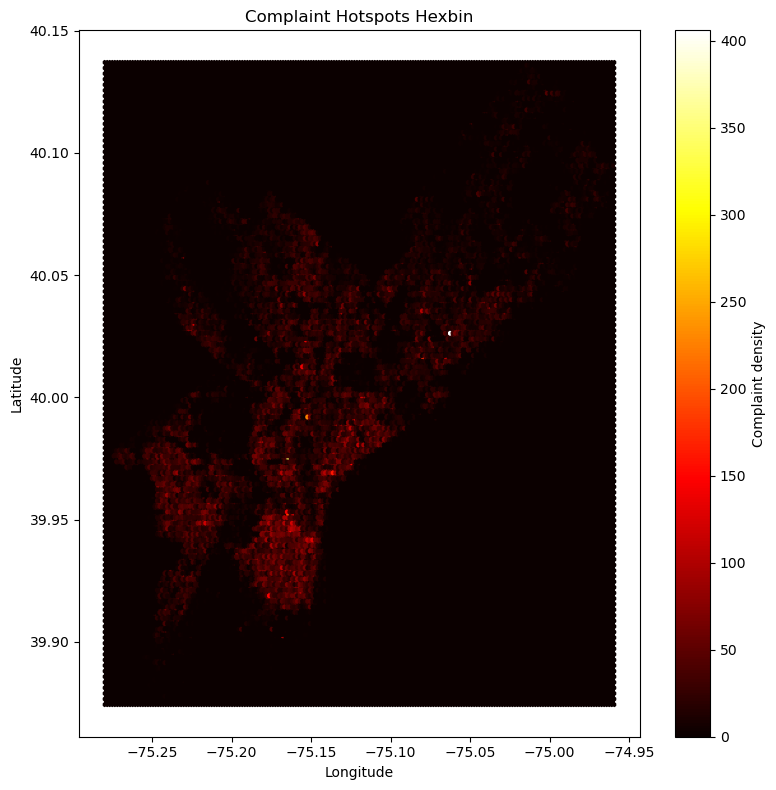

In [5]:
sample = df.sample(n=min(len(df), 200_000), random_state=42)
plt.figure(figsize=(8, 8))
plt.hexbin(sample['complaint_lon'], sample['complaint_lat'], gridsize=200, cmap='hot')
plt.title('Complaint Hotspots Hexbin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Complaint density')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'hotspots_hexbin.png'), dpi=200)
plt.show()

## 2) Business density vs complaint frequency

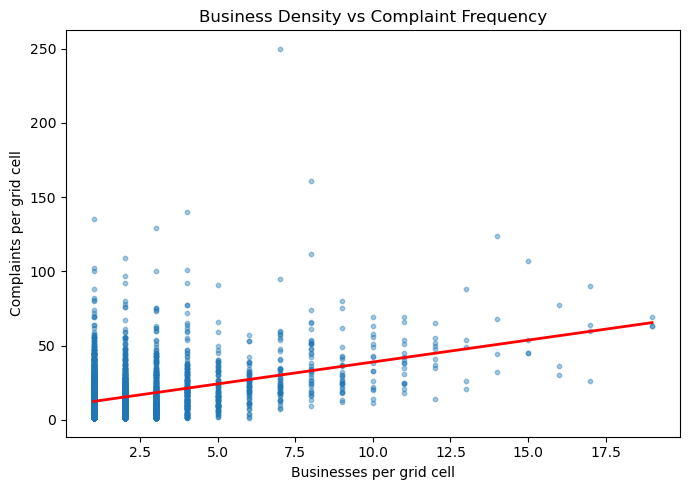

In [6]:
tmp = df_top.copy()
tmp['c_lat_cell'] = tmp['complaint_lat'].round(3)
tmp['c_lon_cell'] = tmp['complaint_lon'].round(3)
tmp['b_lat_cell'] = tmp['business_lat'].round(3)
tmp['b_lon_cell'] = tmp['business_lon'].round(3)

complaint_counts = tmp.groupby(['c_lat_cell', 'c_lon_cell'])['complaint_id'].nunique().rename('complaint_count')
business_counts = tmp.groupby(['b_lat_cell', 'b_lon_cell'])['business_id'].nunique().rename('business_count')
merged = complaint_counts.reset_index().merge(
    business_counts.reset_index(),
    left_on=['c_lat_cell', 'c_lon_cell'],
    right_on=['b_lat_cell', 'b_lon_cell'],
    how='inner'
)

plt.figure(figsize=(7, 5))
plt.scatter(merged['business_count'], merged['complaint_count'], alpha=0.4, s=10)
if len(merged) > 1:
    coef = np.polyfit(merged['business_count'], merged['complaint_count'], 1)
    xx = np.linspace(merged['business_count'].min(), merged['business_count'].max(), 100)
    yy = coef[0] * xx + coef[1]
    plt.plot(xx, yy, color='red', linewidth=2)
plt.title('Business Density vs Complaint Frequency')
plt.xlabel('Businesses per grid cell')
plt.ylabel('Complaints per grid cell')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'density_vs_complaints.png'), dpi=200)
plt.show()

## 3) Clusters of complaint types (TF-IDF + KMeans)

c:\Users\austi\anaconda3\envs\CS4630Proj1\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


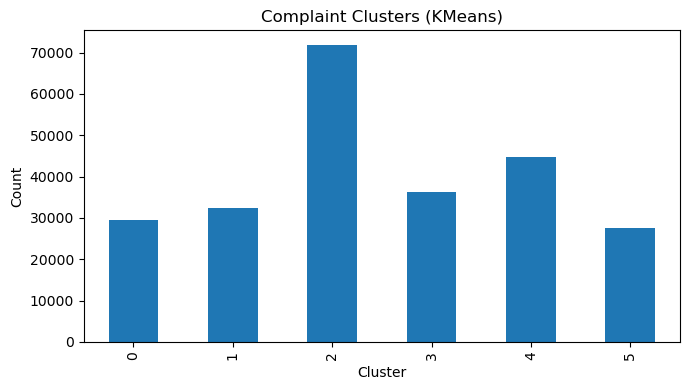

In [7]:
text = df_top['complaint_category'].fillna('') + ' ' + df_top['complaint_service'].fillna('')
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(text)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
df_top['cluster'] = labels

cluster_counts = df_top['cluster'].value_counts().sort_index()
plt.figure(figsize=(7, 4))
cluster_counts.plot(kind='bar')
plt.title('Complaint Clusters (KMeans)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cluster_sizes.png'), dpi=200)
plt.show()

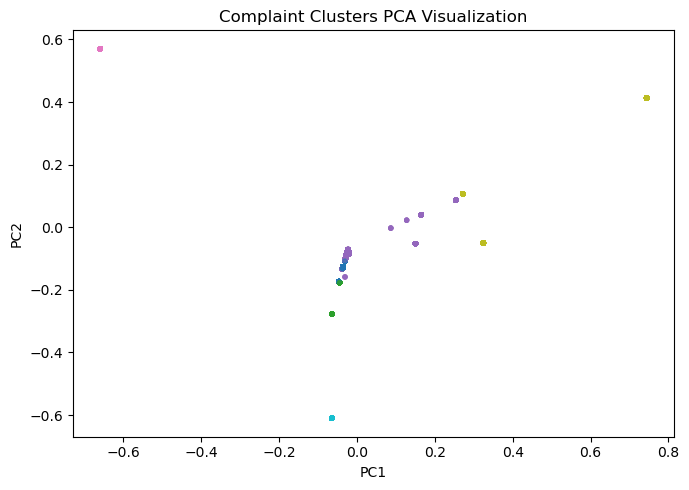

In [8]:
# PCA scatter for cluster visualization
sample = df_top.sample(n=min(len(df_top), 30_000), random_state=42)
text_s = sample['complaint_category'].fillna('') + ' ' + sample['complaint_service'].fillna('')
vectorizer_s = TfidfVectorizer(max_features=2000, stop_words='english')
X_s = vectorizer_s.fit_transform(text_s)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_s.toarray())
plt.figure(figsize=(7, 5))
plt.scatter(X2[:, 0], X2[:, 1], c=sample['cluster'], s=8, alpha=0.5, cmap='tab10')
plt.title('Complaint Clusters PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cluster_pca.png'), dpi=200)
plt.show()

## 4) Complaint patterns near business categories

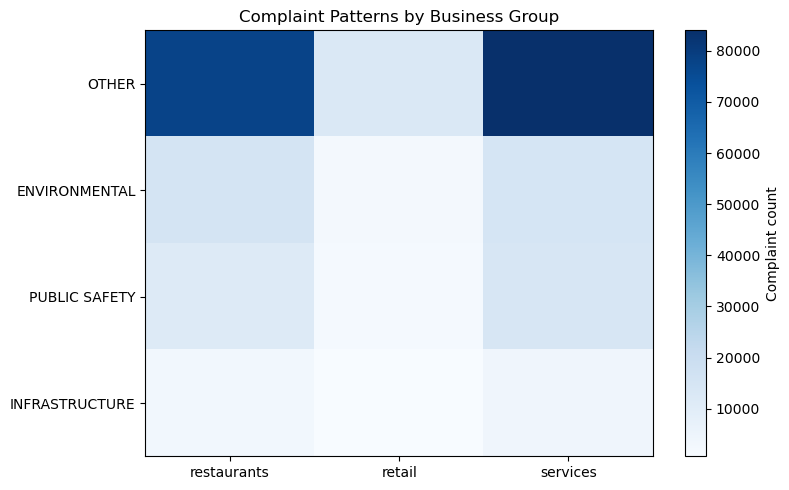

In [9]:
def classify_business_group(category: str) -> str:
    if not isinstance(category, str):
        return "other"
    c = category.lower()
    if any(k in c for k in ["restaurant", "food", "bar", "cafe", "coffee", "pizza"]):
        return "restaurants"
    if any(k in c for k in ["shop", "retail", "store", "market", "grocery", "mall"]):
        return "retail"
    return "services"

df_top["business_group"] = df_top["business_category"].apply(classify_business_group)
top_complaints = df_top["complaint_category"].value_counts().head(10).index
subset = df_top[df_top["complaint_category"].isin(top_complaints)]
pivot = subset.pivot_table(
    index="complaint_category",
    columns="business_group",
    values="complaint_id",
    aggfunc="nunique",
    fill_value=0,
).reindex(top_complaints)

plt.figure(figsize=(8, 5))
plt.imshow(pivot.values, aspect="auto", cmap="Blues")
plt.colorbar(label="Complaint count")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Complaint Patterns by Business Group")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "complaint_patterns_by_business_group.png"), dpi=200)
plt.show()

## 5) Sentiment by complaint category

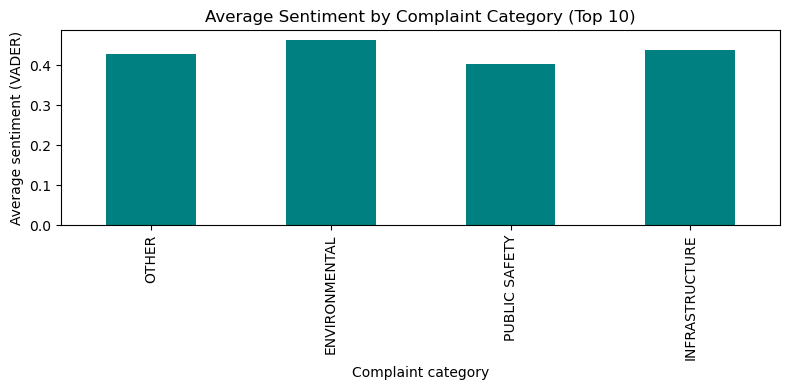

In [ ]:
sent_df = df_top.dropna(subset=["complaint_sentiment", "complaint_category"]).copy()
if len(sent_df) == 0:
    print("No sentiment data available for plotting.")
else:
    top_cats = sent_df["complaint_category"].value_counts().head(10).index
    sent_summary = (
        sent_df[sent_df["complaint_category"].isin(top_cats)]
        .groupby("complaint_category")["complaint_sentiment"]
        .mean()
        .reindex(top_cats)
    )

    plt.figure(figsize=(8, 4))
    sent_summary.plot(kind="bar", color="teal")
    plt.title("Average Sentiment by Complaint Category (Top 10)")
    plt.xlabel("Complaint category")
    plt.ylabel("Average sentiment (VADER)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "sentiment_by_category.png"), dpi=200)
    plt.show()

## 6) Severity distribution by business group

In [11]:
if "business_group" not in df_top.columns:
    df_top["business_group"] = df_top["business_category"].apply(classify_business_group)

sev_df = df_top.dropna(subset=["complaint_severity", "business_group"]).copy()
if len(sev_df) == 0:
    print("No severity data available for plotting.")
else:
    severity_counts = sev_df.pivot_table(
        index="business_group",
        columns="complaint_severity",
        values="complaint_id",
        aggfunc="nunique",
        fill_value=0,
    )

    severity_counts = severity_counts.loc[severity_counts.sum(axis=1).sort_values(ascending=False).index]

    plt.figure(figsize=(8, 4))
    severity_counts.plot(kind="bar", stacked=True, colormap="Set2")
    plt.title("Complaint Severity by Business Group")
    plt.xlabel("Business group")
    plt.ylabel("Unique complaints")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "severity_by_business_group.png"), dpi=200)
    plt.show()

KeyError: ['complaint_severity']